In [315]:
import pandas as pd
import re
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from sklearn.preprocessing import (
    FunctionTransformer,
    RobustScaler,
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder   
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score
)
from sklearn.metrics import (
    r2_score,
    mean_squared_error
)
from sklearn.svm import SVR
from sklearn.cluster import DBSCAN
from xgboost import XGBRegressor
from sklearn.ensemble import IsolationForest, RandomForestRegressor
import optuna
import datetime as dt
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [316]:
df = pd.read_excel('../data/Real estate valuation data set.xlsx', index_col='No')

In [317]:
df.columns

Index(['X1 transaction date', 'X2 house age',
       'X3 distance to the nearest MRT station',
       'X4 number of convenience stores', 'X5 latitude', 'X6 longitude',
       'Y house price of unit area'],
      dtype='object')

In [318]:
pattern = re.compile(r'X(\d+)\s|Y\s')
df.columns = list(map(lambda x: 
                            pattern.sub('', x)
                            .lower().replace(' ', '_'),
                    df.columns.values))



In [319]:
df.head()

,transaction_date,house_age,distance_to_the_nearest_mrt_station,number_of_convenience_stores,latitude,longitude,house_price_of_unit_area
No,,,,,,,
1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


In [320]:
df.reset_index(inplace=True)
df.drop(columns='No', inplace=True)

In [321]:
df['transaction_date'] = df['transaction_date'].copy().astype('int')

In [322]:
df.nunique()

transaction_date                         2
house_age                              236
distance_to_the_nearest_mrt_station    259
number_of_convenience_stores            11
latitude                               234
longitude                              232
house_price_of_unit_area               270
dtype: int64

In [323]:
metadata = {
    'tgt': 'house_price_of_unit_area',
    'num_fts': df.select_dtypes(include='number').columns.tolist(),
    'cat_fts': df.select_dtypes(include='category').columns.tolist(),   
    'n_cols': df.shape[1]
}
metadata

{'tgt': 'house_price_of_unit_area',
 'num_fts': ['transaction_date',
  'house_age',
  'distance_to_the_nearest_mrt_station',
  'number_of_convenience_stores',
  'latitude',
  'longitude',
  'house_price_of_unit_area'],
 'cat_fts': [],
 'n_cols': 7}

In [324]:
def generate_fig(n_df_cols, fig_cols=3):
    fig_rows = (len(n_df_cols) // fig_cols) + 1 if len(n_df_cols) % fig_cols != 0 else len(n_df_cols) // fig_cols
    return fig_rows, fig_cols

In [325]:
fig_rows, fig_cols = generate_fig(metadata['num_fts'])

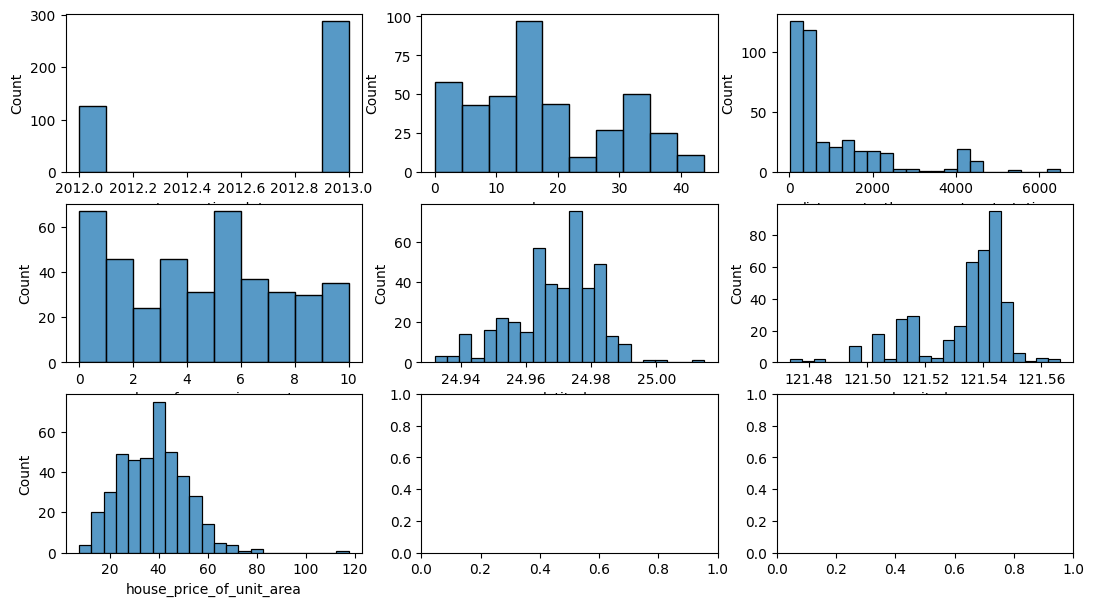

In [326]:
fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(13, 7))

for i, col in enumerate(metadata['num_fts']):
    subp_col = i % fig_cols 
    subp_row = i // fig_cols 
    sns.histplot(df[col], ax=axes[subp_row, subp_col])



In [327]:
tsne = TSNE(n_components=3)

df_tsne = pd.DataFrame(
    data=tsne.fit_transform(df[metadata['num_fts']]),
    columns=tsne.get_feature_names_out()
)

In [328]:
fig = px.scatter_3d(
    data_frame=df_tsne,
    x=df_tsne.columns[0],
    y=df_tsne.columns[1],
    z=df_tsne.columns[2],
    opacity=0.5,
)
fig.show()

In [329]:
scaler = RobustScaler()
isf = IsolationForest(contamination=0.1, random_state=42)
outliers = isf.fit_predict(scaler.fit_transform(df.drop(columns=metadata['tgt'])))
outliers

array([ 1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1, -1,  1, -1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,
       -1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [330]:
df_tsne['outliers'] = outliers.astype(str)
fig = px.scatter_3d(
    data_frame=df_tsne,
    x=df_tsne.columns[0],
    y=df_tsne.columns[1],
    z=df_tsne.columns[2],
    color='outliers',
    color_discrete_map={
        '-1': 'red',
        '1': 'grey'
    }
)
fig.show()

In [331]:
mask = outliers == 1
df = df.loc[mask, :].copy()

In [332]:
Xtrain, Xtest, ytrain, ytest = train_test_split(df.iloc[:,:-1], df.loc[:,metadata['tgt']], test_size=0.2, random_state=42, stratify=df['transaction_date'])    

In [333]:
# custom transformer that uses a KMeans clusterer in the fit() method to identify the main clusters in the training data, and 
# then uses rbf_kernel() in the transform() method to measure how similar each sample is to each cluster center:

from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [334]:
def log_transformer():
    return FunctionTransformer(
        np.log1p,
        feature_names_out='one-to-one'
    )

num_pl = Pipeline(steps=[
    ('scaling',RobustScaler())
])

cat_pl = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pl, ['house_age', 'distance_to_the_nearest_mrt_station']),
    ('cat', cat_pl, ['transaction_date']),
    ('geo', ClusterSimilarity(n_clusters=5, gamma=0.1), ['latitude', 'longitude']),
    ('log', Pipeline(steps=[
            ('log', log_transformer()),
            ('scaling', RobustScaler())
        ]), ['distance_to_the_nearest_mrt_station'])
])

preprocessor.fit(Xtrain)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaling', RobustScaler())]),
                                 ['house_age',
                                  'distance_to_the_nearest_mrt_station']),
                                ('cat',
                                 Pipeline(steps=[('ordinal',
                                                  OrdinalEncoder())]),
                                 ['transaction_date']),
                                ('geo',
                                 ClusterSimilarity(gamma=0.1, n_clusters=5),
                                 ['latitude', 'longitude']),
                                ('log',
                                 Pipeline(steps=[('log',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log1p'>)),
                                                 ('scaling', RobustScaler())]),
                                 ['distance_to_the_nearest_mrt_station'])])

In [335]:
preprocessor.get_feature_names_out()

array(['num__house_age', 'num__distance_to_the_nearest_mrt_station',
       'cat__transaction_date', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'log__distance_to_the_nearest_mrt_station'], dtype=object)

In [336]:
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('model', XGBRegressor(enable_categorical=True))
])

In [337]:
Xtrain

,transaction_date,house_age,distance_to_the_nearest_mrt_station,number_of_convenience_stores,latitude,longitude
115,2013,20.6,737.9161,2,24.98092,121.54739
174,2013,4.3,432.0385,7,24.98050,121.53778
16,2013,0.0,292.9978,6,24.97744,121.54458
298,2013,16.7,4082.0150,0,24.94155,121.50381
412,2013,8.1,104.8101,5,24.96674,121.54067
...,...,...,...,...,...,...
71,2013,35.5,640.7391,3,24.97563,121.53715
177,2013,33.0,181.0766,9,24.97697,121.54262
124,2012,9.9,279.1726,7,24.97528,121.54541
389,2013,40.9,122.3619,8,24.96756,121.54230


In [338]:
full_pipeline.fit(Xtrain, ytrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaling',
                                                                   RobustScaler())]),
                                                  ['house_age',
                                                   'distance_to_the_nearest_mrt_station']),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['transaction_date']),
                                                 ('geo',
                                                  ClusterSimilarity(gamma=0.1,
                                                                    n_clusters=5),
                                                  ['latitude', 'longitude']),
                                                 ('log',
                                                  Pipeline(steps=[('log',...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [339]:
y_train_pred = full_pipeline.predict(Xtrain)
print(r2_score(ytrain, y_train_pred))

0.9891700020502678


In [340]:
y_test_pred = full_pipeline.predict(Xtest)
print(r2_score(ytest, y_test_pred))

0.36295090739021374


In [341]:
lin_pl = Pipeline(steps=[
    ('scaling', RobustScaler()),
    ('model', LinearRegression())
])
lin_pl.fit(Xtrain, ytrain)

Pipeline(steps=[('scaling', RobustScaler()), ('model', LinearRegression())])

In [342]:
y_train_pred = lin_pl.predict(Xtrain)
print(r2_score(ytrain, y_train_pred))

0.5401967286725331


In [343]:
y_test_pred = lin_pl.predict(Xtest)
print(r2_score(ytest, y_test_pred))

0.6422034118208824


In [344]:
scores = cross_val_score(
    cv=KFold(shuffle=True, random_state=42),
    estimator=lin_pl,
    scoring='neg_root_mean_squared_error',
    X=Xtrain,
    y=ytrain
)

(2.2190988793642323, -9.08139508202047)

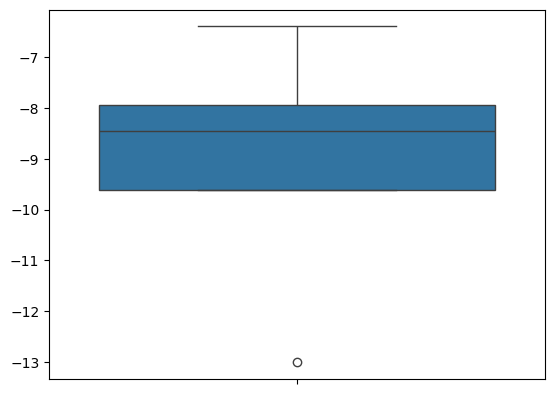

In [345]:
sns.boxplot(scores)
np.std(scores), np.mean(scores)

In [346]:
models = [
    LinearRegression(),
    Lasso(),
    Ridge(),
    SVR(),
    RandomForestRegressor(),
    XGBRegressor()
]

In [368]:
from sklearn.metrics import make_scorer


lin_models = {
    model.__class__.__name__: cross_val_score(
        cv=KFold(shuffle=True, random_state=42, n_splits=10),
        estimator=Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('model', model)
            ]),
        scoring='neg_root_mean_squared_error',
        X=Xtrain,
        y=ytrain,
        n_jobs=-1
    )
    for model in models
}

In [369]:
df = pd.DataFrame(
data=lin_models
)

In [370]:
df

,LinearRegression,Lasso,Ridge,SVR,RandomForestRegressor,XGBRegressor
0,-3.907529,-6.068201,-5.187667,-6.492332,-4.700841,-4.885311
1,-6.227278,-8.643266,-7.753209,-7.949922,-4.490907,-4.434875
2,-15.573421,-15.564142,-15.229788,-15.316928,-14.751107,-15.876498
3,-9.200246,-11.029407,-10.176108,-10.430690,-8.326068,-8.344552
4,-8.274100,-9.302623,-9.036860,-9.248247,-6.780756,-11.229349
5,-6.097551,-5.600986,-6.088069,-5.758535,-5.157679,-4.981731
6,-5.712916,-5.989620,-6.163082,-6.060778,-5.704242,-8.012734
7,-7.991198,-8.935981,-8.987104,-8.113029,-7.872672,-9.723031
8,-8.314249,-9.113152,-8.945283,-9.191301,-10.029527,-9.854760
9,-9.627431,-10.555222,-9.882554,-10.750261,-7.490626,-8.081388


<Axes: xlabel='house_price_of_unit_area', ylabel='Count'>

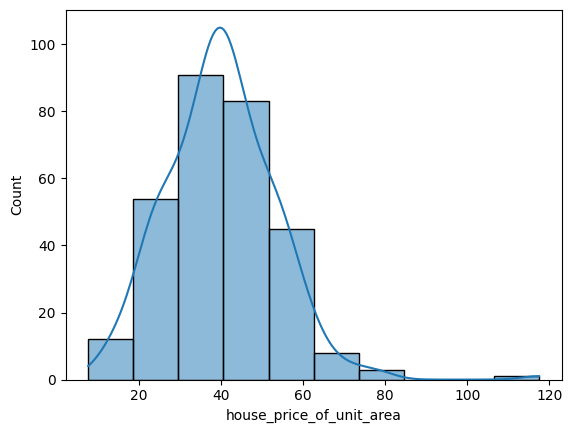

In [379]:
sns.histplot(ytrain, kde=True, bins=10)

<Axes: >

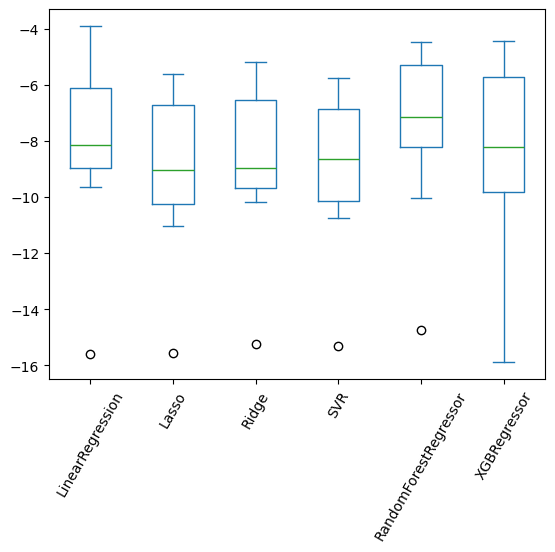

In [380]:
df.plot(kind='box', rot=60)

# Tuning Ridge

In [382]:
def objective(trial):
    params = {
        'alpha': trial.suggest_float('alpha', 0.1, 1.0),
        'solver': trial.suggest_categorical('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']),
        'tol': trial.suggest_float('tol', 1e-5, 1e-3),
        'random_state': 42,
        'max_iter': trial.suggest_int('max_iter', 1000, 10000),
    }

    model = Ridge(**params)
    scores = cross_val_score(
        cv=KFold(shuffle=True, random_state=42, n_splits=10),
        estimator=Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ]),
        scoring='neg_root_mean_squared_error',
        X=Xtrain,
        y=ytrain,
        n_jobs=-1
    )
    return np.mean(scores)

study = optuna.create_study(direction='minimize', study_name='Ridge',sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100)


[I 2024-05-29 19:39:01,749] A new study created in memory with name: Ridge
[I 2024-05-29 19:39:01,817] Trial 0 finished with value: -8.747240206733988 and parameters: {'alpha': 0.4370861069626263, 'solver': 'auto', 'tol': 0.0006051038616257768, 'max_iter': 7373}. Best is trial 0 with value: -8.747240206733988.
[I 2024-05-29 19:39:01,872] Trial 1 finished with value: -8.74864502901244 and parameters: {'alpha': 0.1185260448662222, 'solver': 'auto', 'tol': 0.00043762556845569465, 'max_iter': 3621}. Best is trial 1 with value: -8.74864502901244.
[I 2024-05-29 19:39:01,932] Trial 2 finished with value: -8.746348372619593 and parameters: {'alpha': 0.6506676052501416, 'solver': 'sparse_cg', 'tol': 0.0005964904231734221, 'max_iter': 1418}. Best is trial 1 with value: -8.74864502901244.
[I 2024-05-29 19:39:02,000] Trial 3 finished with value: -8.74636423486459 and parameters: {'alpha': 0.6467903667112945, 'solver': 'lsqr', 'tol': 0.0006873906962470354, 'max_iter': 4961}. Best is trial 1 with va

In [352]:
ridge_best_params = study.best_params

In [353]:
optmized_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge(**ridge_best_params))
])
optmized_ridge.fit(Xtrain, ytrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaling',
                                                                   RobustScaler())]),
                                                  ['house_age',
                                                   'distance_to_the_nearest_mrt_station']),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['transaction_date']),
                                                 ('geo',
                                                  ClusterSimilarity(gamma=0.1,
                                                                    n_clusters=5),
                                                  ['latitude', 'longitude']),
                                                 ('log',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>)),
                                                                  ('scaling',
                                                                   RobustScaler())]),
                                                  ['distance_to_the_nearest_mrt_station'])])),
                ('model',
                 Ridge(alpha=0.9998686187465673, max_iter=8034, solver='svd',
                       tol=0.000322119609145909))])

In [354]:
optmized_ridge.score(Xtrain, ytrain)

0.542135048922852

In [355]:
print(r2_score(ytrain, optmized_ridge.predict(Xtrain)))

0.542135048922852


In [356]:
print(r2_score(ytest, optmized_ridge.predict(Xtest)))

0.618471670240544


# Tuning SVR

In [357]:
def objective(trial):
    params ={
        'epsilon': trial.suggest_float('epsilon', 0.5, 1.0, log=True),
        'C': trial.suggest_float('C', 0.5, 1.0, log=True),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
    }
    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', SVR(**params))
    ])
    full_pipeline.fit(Xtrain, ytrain)
    
    
    return r2_score(ytrain, full_pipeline.predict(Xtrain))

study = optuna.create_study(direction='maximize', study_name='SVR',sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=500)

[I 2024-05-29 19:29:02,086] A new study created in memory with name: SVR
[I 2024-05-29 19:29:02,103] Trial 0 finished with value: 0.5291490861390061 and parameters: {'epsilon': 0.6482131165247735, 'C': 0.9664147012279757, 'kernel': 'linear'}. Best is trial 0 with value: 0.5291490861390061.
[I 2024-05-29 19:29:02,116] Trial 1 finished with value: 0.1859214783194002 and parameters: {'epsilon': 0.520540966199949, 'C': 0.9114125527116832, 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.5291490861390061.
[I 2024-05-29 19:29:02,130] Trial 2 finished with value: 0.3320990634214396 and parameters: {'epsilon': 0.8903488639350978, 'C': 0.5792825495506346, 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.5291490861390061.
[I 2024-05-29 19:29:02,144] Trial 3 finished with value: 0.527876961790773 and parameters: {'epsilon': 0.6745255603940726, 'C': 0.6118411902896104, 'kernel': 'linear'}. Best is trial 0 with value: 0.5291490861390061.
[I 2024-05-29 19:29:02,161] Trial 4 finished with value

In [358]:
best_svr_params = study.best_params
best_svr_params

{'epsilon': 0.9448084119545512, 'C': 0.9998909215054468, 'kernel': 'poly'}

In [359]:
best_svr_params = study.best_params
opt_svr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SVR(**best_svr_params))
])
opt_svr.fit(Xtrain, ytrain)
print('r2 score on train set: ',r2_score(ytrain, opt_svr.predict(Xtrain)))
print('r2 score on test set',r2_score(ytest, opt_svr.predict(Xtest)))

r2 score on train set:  0.5699346456647838
r2 score on test set 0.6784718565693368


In [360]:
preprocessor.fit_transform(Xtrain)

array([[ 0.29347826,  0.39922159,  1.        , ...,  0.9996506 ,
         0.99998009,  0.37288806],
       [-0.5923913 , -0.04191477,  1.        , ...,  0.99973281,
         0.99998046, -0.05160233],
       [-0.82608696, -0.24243913,  1.        , ...,  0.99970028,
         0.9999899 , -0.35923473],
       ...,
       [-0.28804348, -0.26237782,  0.        , ...,  0.99970713,
         0.99999338, -0.39749784],
       [ 1.39673913, -0.48853005,  1.        , ...,  0.99977621,
         0.99999995, -1.04912586],
       [-0.11956522,  0.04489522,  0.        , ...,  0.99982498,
         0.9999963 ,  0.05178926]])

In [361]:
trsf_df = pd.DataFrame(
    data=preprocessor.transform(Xtrain),
    columns=preprocessor.get_feature_names_out()
)
trsf_df

,num__house_age,num__distance_to_the_nearest_mrt_station,cat__transaction_date,geo__Cluster 0 similarity,geo__Cluster 1 similarity,geo__Cluster 2 similarity,geo__Cluster 3 similarity,geo__Cluster 4 similarity,log__distance_to_the_nearest_mrt_station
0,0.293478,0.399222,1.0,0.999992,0.999864,0.999927,0.999651,0.999980,0.372888
1,-0.592391,-0.041915,1.0,1.000000,0.999920,0.999930,0.999733,0.999980,-0.051602
2,-0.826087,-0.242439,1.0,0.999996,0.999892,0.999946,0.999700,0.999990,-0.359235
3,0.081522,5.222078,1.0,0.999741,0.999935,0.999836,0.999999,0.999779,1.730830
4,-0.385870,-0.513843,1.0,0.999985,0.999930,0.999985,0.999793,0.999999,-1.171046
...,...,...,...,...,...,...,...,...,...
292,1.103261,0.259073,1.0,0.999999,0.999936,0.999952,0.999771,0.999990,0.260877
293,0.967391,-0.403852,1.0,0.999998,0.999904,0.999949,0.999720,0.999991,-0.739864
294,-0.288043,-0.262378,0.0,0.999994,0.999892,0.999955,0.999707,0.999993,-0.397498
295,1.396739,-0.488530,1.0,0.999986,0.999920,0.999983,0.999776,1.000000,-1.049126


<Axes: title={'center': 'Transformed Features'}>

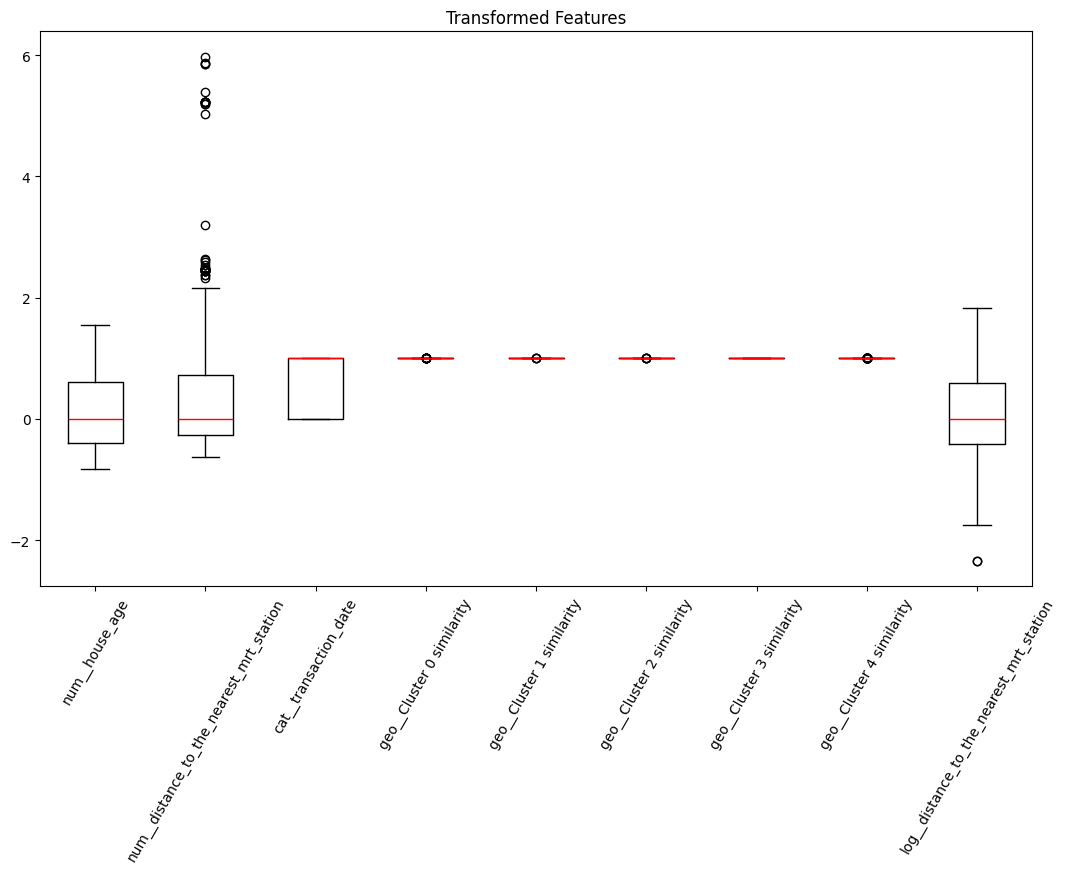

In [362]:
trsf_df.plot(kind='box', rot = 60, figsize=(12.8,7.2), title='Transformed Features', color=dict(boxes='black', whiskers='black', medians='red', caps='black'))

In [363]:
from sklearn.metrics.pairwise import rbf_kernel

In [364]:
# fig = px.scatter_mapbox(
#     data_frame=df,
#     lat='latitude',
#     lon='longitude',
#     color='house_price_of_unit_area',
#     zoom=10,
#     center=dict(lat=df['latitude'].median(), lon=df['longitude'].median()),
#     mapbox_style='carto-positron'
# )
# fig.update_layout(
#     width=1280,
#     height=720,
#     margin=dict(l=0, r=0, t=0, b=0)
# )
# fig.add_trace(go.Scattermapbox(
#     lat=k_centroids['lat'],
#     lon=k_centroids['lon'],
#     mode='markers',
#     marker=dict(size=20, color='red'),
# ))
# fig.show()